# Introduction

This notebook guides through calibration function development using published data (S. De Vito et al., Sensors and Actuators B: Chemical, Volume 129, Issue 2).

In [3]:
# Load libriaries.
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.size'] = 6.0
plt.rcParams['axes.titlesize'] = 6.0

# Method(s)
A Bayesian neural network is used as machine learning algorithm.

In [4]:
# Define helper functions.
scaler = StandardScaler(copy=True) # Define standard scaler instance.
imputer = SimpleImputer()
detector = IsolationForest(n_estimators=1000, random_state=0) # Define outlier detector instance.
dim_red = PCA(n_components=2) # Define principal components instance.

In [5]:
# Define moving-average function.
def moving_average(x, w=168*4):
    return np.convolve(x, np.ones(w), "same") / w

# Create Meshgrid.
def make_meshgrid(x, y, h=0.25):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 6, x.max() + 6
    y_min, y_max = y.min() - 6, y.max() + 6
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
    
def compute_predictions(model, dim_red, x, y, n_outputs=4, n_iterations=30):
    xx, yy = make_meshgrid(x, y)
    shape = xx.shape
    xx, yy = xx.ravel(), yy.ravel()
    length = xx.shape[0]
    X, Y = np.zeros((length, 1)), np.zeros((length, 1))
    output = np.zeros((n_iterations, n_outputs))
    mu, sigma = np.zeros((length, n_outputs)), np.zeros((length, n_outputs))
    for index in range(length):
        data = np.expand_dims(dim_red.inverse_transform([xx[index], yy[index]]), axis=0)
        for k in range(n_iterations):
            output[k, :] = model.predict(data)
        X[index, 0], Y[index, 0] = xx[index], yy[index]
        mu[index, :], sigma[index, :] = np.mean(output, axis=0), np.std(output, axis=0)
    return X, Y, mu, sigma, shape

def run_simulation(model, data, T=None, n_outputs=4, n_iterations=30):
    if T == None:
        T = data.shape[0]
    mu = np.zeros((T, n_outputs))
    sigma = np.zeros((T, n_outputs))
    output = np.zeros((n_iterations, n_outputs))
    for t in range(T):
        for k in range(n_iterations):
            output[k, :] = model.predict(np.expand_dims(data[t, :], axis=0))
        mu[t, :] = np.mean(output, axis=0)
        sigma[t, :] = np.std(output, axis=0)
    return mu, sigma

# Data Handling
Load data to pandas data frame.

In [6]:
# Load data and keep only first six months.
data = pd.read_excel("AirQualityUCI.xlsx")
data = data[data["Date"] <= "2004-09-10"]

# Visualize data summary.
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,3447.000000,4275.000000,914.000000,4275.000000,4275.000000,3525.000000,4275.000000,3522.000000,4275.000000,4275.000000,4275.000000,4275.000000,4275.000000
mean,1.918422,1077.334113,218.811816,9.850661,937.848090,126.051348,897.271150,94.706133,1617.936394,944.460370,23.451201,42.485045,1.153040
std,1.206673,200.344215,204.459921,6.566329,240.489984,83.970746,228.686816,36.637686,255.788785,343.175279,7.843419,15.985736,0.343338
min,0.100000,708.000000,7.000000,0.464418,437.000000,2.000000,387.500000,5.000000,955.000000,263.000000,6.100000,9.175000,0.375444
25%,1.000000,932.250000,67.000000,4.843458,755.500000,63.000000,735.875000,67.000000,1441.750000,692.875000,17.300000,29.500000,0.904255
50%,1.700000,1047.500000,150.000000,8.499723,919.500000,108.000000,860.000000,94.000000,1587.000000,896.500000,23.450000,42.500000,1.096318
75%,2.500000,1184.250000,297.000000,13.385657,1096.500000,168.000000,1022.750000,119.000000,1752.625000,1150.625000,28.600000,54.000000,1.366492
max,8.100000,2039.750000,1189.000000,40.260061,1776.250000,631.000000,1940.750000,233.000000,2746.000000,2474.750000,44.600000,85.150002,2.180639


# Methods
The data is preprocessed and sliced into different sets. Data is scaled before analysis. In particular, standard scaling provides better results with respect to R2 score and explained variance.
No imputation is performed.

In [7]:
# Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns].dropna(axis=0)

# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)

# Optional: Impute missing values.
# X_t = imputer.fit_transform(X_t)

# Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]

# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)

# Define inputs/outputs.
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

In [13]:
# Define some hyperparameters.
n_epochs = 200
n_samples = dataset.shape[0]
n_batches = 50
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [14]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t[..., :n],
            scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [15]:
# Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)

# Define negative logarithmic likelihood.
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

# Define model instance.
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfp.layers.DenseVariational(10, posterior_mean_field, prior_trainable, 
                            activation="relu", kl_weight=1/n_samples, name="dense_1"),
tfp.layers.DenseVariational(tfp.layers.MultivariateNormalTriL.params_size(len(outputs)),
                            posterior_mean_field, prior_trainable, 
                            activation="linear", kl_weight=1/n_samples, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), name="output")
], name="model")

# Compile model.
model.compile(optimizer="Adam", loss=neg_log_likelihood)

# Describe model.
model.summary()
# plot_model(model, to_file='./figures/model.png', show_shapes=True, expand_nested=True, dpi=900)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (DenseVariational)   (None, 10)                210       
_________________________________________________________________
distribution_weights (DenseV (None, 14)                462       
_________________________________________________________________
output (MultivariateNormalTr multiple                  0         
Total params: 672
Trainable params: 672
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Run training session.
model.load_weights("./Bayesian_neural_network")
# model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True)
# model.save_weights("./Bayesian_neural_network")

# Results and Discussion

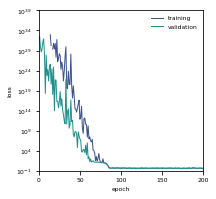

In [29]:
# Plot the training session.
fig = plt.figure(figsize=(2.95, 2.95))
fig.tight_layout()
plt.yscale("log")
plt.xlim(0, np.round(len(model.history.epoch)+4,-1))
plt.xticks(np.linspace(0, np.round(len(model.history.epoch)+4,-1), 5))
plt.ylim(1e-1, 1e39)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(list(map(lambda x: x + 1, model.history.epoch)), model.history.history["loss"], label="training", color=plt.cm.viridis(0.25))
plt.plot(list(map(lambda x: x + 1, model.history.epoch)), model.history.history["val_loss"], label="validation", color=plt.cm.viridis(0.5))
plt.legend(frameon=False, loc=0)
plt.savefig('./figures/loss_BNN',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [21]:
# Predict.
Y_true = dataset[outputs].values
Y_pred = np.zeros(shape=dataset[outputs].shape)
k = 100
for _ in range(k):
    Y_pred += (1/k)*model.predict(dataset[inputs])

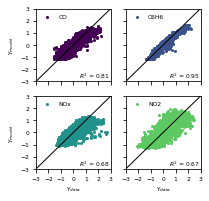

In [30]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
for k in range(n_v):
    ax[k].plot([-3, 3], [-3, 3], color="k")
    ax[k].scatter(Y_true[:, k], Y_pred[:, k], color=colors[k], s=4, alpha=1.0, label=labels[k])
    ax[k].text(0.45, -2.75, "$R^2$ = "+str(np.round(r2_score(Y_true[:, k], Y_pred[:, k]), 2)))
    ax[k].legend(frameon=False)
    if k % 2 == 0:
        ax[k].set_ylabel("Y$_{model}$")
    if k // 2 != 0:
        ax[k].set_xlabel("Y$_{data}$")
    ax[k].set_xlim(-3, 3)
    ax[k].set_ylim(-3, 3)
    ax[k].set_xticks(np.round(np.linspace(-3, 3, 7), 2))
    ax[k].set_yticks(np.round(np.linspace(-3, 3, 7), 2))
plt.savefig('./figures/agreement',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

In [19]:
Y_red = dim_red.fit_transform(dataset[inputs])
# X, Y, mu, sigma, shape = compute_predictions(model, dim_red, Y_red[:, 0], Y_red[:, 1])
X, Y, mu, sigma, shape = np.load("X.npy"), np.load("Y.npy"), np.load("mu.npy"), np.load("sigma.npy"), np.load("shape.npy")

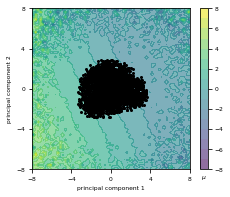

In [14]:
mu[np.abs(mu) > 8] = 8

fig = plt.figure(figsize=(1.2*2.95,2.95))
ax = fig.add_subplot(111)
levels = np.linspace(-8, 8, 17)
xx, yy, Z = X.reshape(shape), Y.reshape(shape), np.mean(mu, axis=-1).reshape(shape)
surf = ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.6, levels=levels)
cbar = plt.colorbar(surf)
cbar.ax.set_xlabel(r"$\mu$")
ax.scatter(Y_red[:, 0], Y_red[:, 1], color="k", s=4, alpha=1.0)
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_xticks(np.round(np.linspace(-8, 8, 5), 2))
ax.set_yticks(np.round(np.linspace(-8, 8, 5), 2))
plt.savefig('./figures/dim_red_mean',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

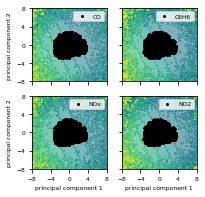

In [12]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
levels = np.linspace(-8, 8, 17)
for k in range(n_v):
    xx, yy, Z = X.reshape(shape), Y.reshape(shape), mu[:, k].reshape(shape)
    ax[k].contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.6, levels=levels)
    ax[k].scatter(Y_red[:, 0], Y_red[:, 1], color="k", s=4, alpha=1.0, label=labels[k])
    ax[k].legend(frameon=True)
    if k % 2 == 0:
        ax[k].set_ylabel("principal component 2")
    if k // 2 != 0:
        ax[k].set_xlabel("principal component 1")
    ax[k].set_xlim(-8, 8)
    ax[k].set_ylim(-8, 8)
    ax[k].set_xticks(np.round(np.linspace(-8, 8, 5), 2))
    ax[k].set_yticks(np.round(np.linspace(-8, 8, 5), 2))
plt.savefig('./figures/dim_red_mean_ind',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

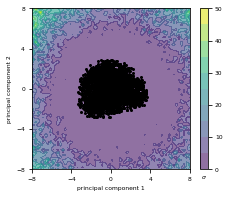

In [15]:
sigma[sigma > 50] = 50

fig = plt.figure(figsize=(1.2*2.95,2.95))
ax = fig.add_subplot(111)
xx, yy, Z = X.reshape(shape), Y.reshape(shape), np.mean(sigma, axis=-1).reshape(shape)
levels = np.linspace(0, 50, 11)
surf = ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.6, levels=levels)
cbar = plt.colorbar(surf)
cbar.ax.set_xlabel(r"$\sigma$")
ax.scatter(Y_red[:, 0], Y_red[:, 1], color="k", s=4, alpha=1.0)
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_xticks(np.round(np.linspace(-8, 8, 5), 2))
ax.set_yticks(np.round(np.linspace(-8, 8, 5), 2))
plt.savefig('./figures/dim_red_unc',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

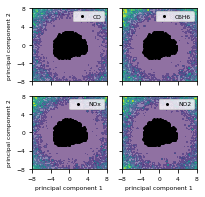

In [16]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
levels = np.linspace(0, 50, 11)
for k in range(n_v):
    xx, yy, Z = X.reshape(shape), Y.reshape(shape), sigma[:, k].reshape(shape)
    ax[k].contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.6, levels=levels)
    ax[k].scatter(Y_red[:, 0], Y_red[:, 1], color="k", s=4, alpha=1.0, label=labels[k])
    ax[k].legend(frameon=True)
    if k % 2 == 0:
        ax[k].set_ylabel("principal component 2")
    if k // 2 != 0:
        ax[k].set_xlabel("principal component 1")
    ax[k].set_xlim(-8, 8)
    ax[k].set_ylim(-8, 8)
    ax[k].set_xticks(np.round(np.linspace(-8, 8, 5), 2))
    ax[k].set_yticks(np.round(np.linspace(-8, 8, 5), 2))
plt.savefig('./figures/dim_red_unc_ind',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

In [21]:
y_regular = []
for _ in range(500):
    y_regular.append(model.predict(np.expand_dims(dim_red.inverse_transform([0, 0]), axis=0)))
y_regular = np.squeeze(np.array(y_regular), axis=1)

In [22]:
mu1 = np.mean(y_regular, axis=0)
sigma1 = np.std(y_regular, axis=0)

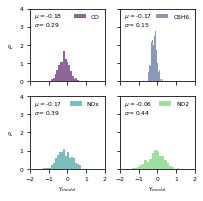

In [23]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
for k in range(n_v):
    ax[k].hist(y_regular[:, k], density=True, bins=21, color=colors[k], alpha=0.6, label=labels[k])
    ax[k].text(-1.8, 3.5, "$\mu=$"+str(np.round(mu1[k],1)))
    ax[k].text(-1.8, 3, "$\sigma=$"+str(np.round(sigma1[k],1)))
    ax[k].legend(frameon=False)
    if k % 2 == 0:
        ax[k].set_ylabel(r"$\rho$")
    if k // 2 != 0:
        ax[k].set_xlabel("Y$_{model}$")
    ax[k].set_xlim(-2, 2)
    ax[k].set_ylim(0, 4)
plt.savefig('./figures/regular',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

In [38]:
y_irregular = []
for _ in range(500):
    y_irregular.append(model.predict(np.expand_dims(dim_red.inverse_transform([-6, -6]), axis=0)))
y_irregular = np.squeeze(np.array(y_irregular), axis=1)

In [39]:
mu2 = np.mean(y_irregular, axis=0)
sigma2 = np.std(y_irregular, axis=0)

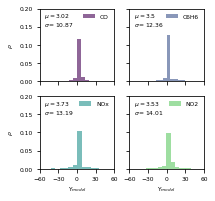

In [48]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
for k in range(n_v):
    ax[k].hist(y_irregular[:, k], density=True, bins=31, color=colors[k], alpha=0.6, label=labels[k])
    ax[k].text(-53, 0.175, "$\mu=$"+str(np.round(mu2[k],1)))
    ax[k].text(-53, 0.15, "$\sigma=$"+str(np.round(sigma2[k],1)))
    ax[k].legend(frameon=False)
    if k % 2 == 0:
        ax[k].set_ylabel(r"$\rho$")
    if k // 2 != 0:
        ax[k].set_xlabel("Y$_{model}$")
    ax[k].set_xlim(-60, 60)
    ax[k].set_xticks(np.linspace(-60, 60, 5))
    ax[k].set_ylim(0, 0.20)
plt.savefig('./figures/irregular',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

In [21]:
# Load data and keep only second six months.
data_test = pd.read_excel("AirQualityUCI.xlsx")
data_test = data_test[data_test["Date"] >= "2004-09-10"]

# Impute missing values.
X_t = imputer.fit_transform(data_test[columns])

# Scale.
X_t = scaler.transform(X_t)

# Restore frame.
dataset_test = pd.DataFrame(X_t, columns=columns, index=data_test["Date"]+pd.to_timedelta([t.isoformat() for t in data_test["Time"].values]))

In [2]:
T = None
n_outputs = 4

# mu_, sigma_ = run_simulation(model, dataset_test[inputs].values, T, n_outputs)
mu_, sigma_ = np.load("mu_.npy"), np.load("sigma_.npy")

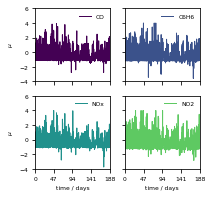

In [18]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
for k in range(n_v):
    ax[k].plot(mu_[:, k], color=colors[k], label=labels[k])
    ax[k].legend(frameon=False)
    if k % 2 == 0:
        ax[k].set_ylabel(r"$\mu$")
    if k // 2 != 0:
        ax[k].set_xlabel("time / days")
    ax[k].set_ylim(-4, 6)
    ax[k].set_xlim(0, 4512)
    ax[k].set_xticks(np.linspace(0, 4512, 5, dtype=int))
    ax[k].set_xticklabels(np.linspace(0, (4512/24), 5, dtype=int))
plt.savefig('./figures/mu_test',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

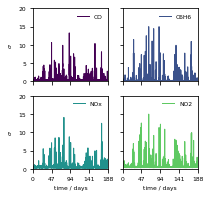

In [19]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig, axes = plt.subplots(figsize=(2.95, 2.95), ncols=2, nrows=2, sharex=True, sharey=True)
ax = axes.ravel()
for k in range(n_v):
    ax[k].plot(sigma_[:, k], color=colors[k], label=labels[k])
    ax[k].legend(frameon=False)
    if k % 2 == 0:
        ax[k].set_ylabel(r"$\sigma$")
    if k // 2 != 0:
        ax[k].set_xlabel("time / days")
    ax[k].set_ylim(0, 20)
    ax[k].set_xlim(0, 4512)
    ax[k].set_xticks(np.linspace(0, 4512, 5, dtype=int))
    ax[k].set_xticklabels(np.linspace(0, (4512/24), 5, dtype=int))
plt.savefig('./figures/sigma_test',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

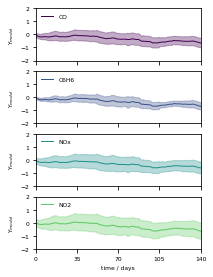

In [5]:
n_v = 4
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig, axes = plt.subplots(figsize=(1.0*2.95, 1.5*2.95), ncols=1, nrows=4, sharex=True, sharey=True)
ax = axes.ravel()
for k in range(n_v):
    ax[k].plot(np.arange(0, mu_.shape[0], 1), moving_average(mu_[:, k]), color=colors[k], label=labels[k])
    ax[k].fill_between(np.arange(0, mu_.shape[0], 1), 
                       moving_average(mu_[:, k]) - moving_average(sigma_[:, k]),
                       moving_average(mu_[:, k]) + moving_average(sigma_[:, k]), 
                       color=colors[k], alpha=0.33)
    ax[k].legend(frameon=False, loc=2)
    ax[k].set_ylabel("Y$_{model}$")
    ax[k].set_ylim(-2, 2)
    ax[k].set_yticks(np.linspace(-2, 2, 5))
    ax[k].set_xlim(0, 3360)
    ax[k].set_xticks(np.linspace(0, 3360, 5, dtype=int))
    ax[k].set_xticklabels(np.linspace(0, (3360/24), 5, dtype=int))
ax[k].set_xlabel("time / days")
plt.savefig('./figures/mu_sigma_test',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

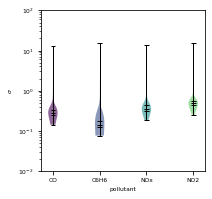

In [4]:
# Plot violinplot.
labels = ["CO", "C6H6", "NOx", "NO2"]
colors = [plt.cm.viridis(0.0), plt.cm.viridis(0.25), plt.cm.viridis(0.50), plt.cm.viridis(0.75)]
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
vp = plt.violinplot(sigma_,
                 widths=0.2, points=1000, showmeans=False, showmedians=True, showextrema=True, quantiles=[[0.25, 0.75]]*n_outputs)
for k, vp_ in enumerate(vp["bodies"]):
    vp_.set_facecolor(colors[k])
    vp_.set_alpha(0.6)
    
for partname in list(vp.keys())[1:]:
    vp_ = vp[partname]
    vp_.set_edgecolor("k")
    vp_.set_alpha(1.0)
plt.xlabel(r"pollutant")
plt.ylabel("$\sigma$")
plt.xticks((1,2,3,4),labels)
plt.yscale("log")
plt.ylim(0.01, 100)
plt.savefig("./figures/box_plot_sigma",dpi=900,transparent=True,orientation="landscape",bbox_inches="tight")
plt.show()

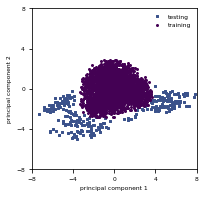

In [22]:
Y_irreg = dim_red.transform(dataset_test[inputs].loc[np.max(sigma_, axis=1) > 1])

fig = plt.figure(figsize=(2.95,2.95))
ax = fig.add_subplot(111)
ax.scatter(Y_irreg[:, 0], Y_irreg[:, 1], color=plt.cm.viridis(0.25), marker="s", s=4, alpha=1.0, label="testing")
ax.scatter(Y_red[:, 0], Y_red[:, 1], color=plt.cm.viridis(0.0), s=4, alpha=1.0, label="training")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_xticks(np.round(np.linspace(-8, 8, 5), 2))
ax.set_yticks(np.round(np.linspace(-8, 8, 5), 2))
plt.legend(frameon=False)
plt.savefig('./figures/anomalies',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()